<a href="https://colab.research.google.com/github/Mael-zys/IMA207/blob/main/TP4_IMA207_yangsong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install munkres

In [ ]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres

**I - Data generation and manipulation**

In this practical session we will use two datasets :
- a first simple one, to understand how the SPA iterations work ;
- a real hyperspectral one, called urban.
Urban is one of the most widely used hyperspectral data used for hyperspectral unmixing studies. There are 307 x 307 pixels, each of which corresponds to a 2 x 2 m2 area. There are 210 wavelengths ranging from 400 nm  to 2500 nm, resulting in a spectral resolution of 10 nm. After the channels 1--4, 76, 87, 101--111, 136--153 and 198--210 are removed (due to dense water vapor and atmospheric effects), we obtain 162  channels.
Interestingly enough, a ground truth have been established. The one we will use contains 6 endmembers (i.e. sources).

**1) Simple dataset**

We propose to generate a very simple dataset, for visual purposes, as follows:
- the mixing matrix **A** will be a m x n matrix with its coefficients generated randomly in [0,10]. When you obtain such a realisation, verify that **A** is not too badly conditioned.
- the source matrix **S** will be a n x t matrix with random coefficients in [0,1] but will be scalled so that the l1-norm of each of its columns sum to 1.
- There will be no noise.

6.911072899138656


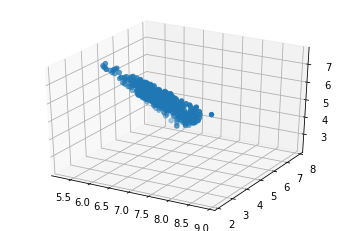

In [ ]:
# TO DO : generate A according to the above description.
# TO DO : compute the condition number of A. What would be the issue with an ill-conditioned mixing matrix?
# TO DO : generate S according to the above conditions.
# TO DO : generate X with a linear mixing

n = 3
m = 3
t = 500

A_toy = np.random.randint(11,size=(m,n))

print(np.linalg.norm(A_toy)*np.linalg.norm(np.linalg.inv(A_toy)))
S_toy = np.random.rand(n,t) 
S_toy /= np.sum(np.abs(S_toy), axis=0).reshape(-1)

X_toy = A_toy @ S_toy


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_toy[0,:],X_toy[1,:],X_toy[2,:])

**2) Real hyperspectral data set** 

First, upload in your working environment the two files Urban.mat and end6_groundTruth.mat, which can be found at https://partage.imt.fr/index.php/s/F7cRFrAre5neA9o

Here, we will use the "Urban" dataset:
- The data matrix **X = AS + N**, which has been acquired by a true sensor ;
- The groundtruth **S_gt**, which corresponds to the "true" abundances (sur groundtruth can for instance be found by on earth geological inquiries). Note that having access to **S_gt** is exceptional: for most other datasets, it would be unknown.

In [ ]:
if 'google.colab' in str(get_ipython()):
  from IPython.display import clear_output
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1Gp8HL4WhPAjYOhJRYHYexhMVs-uv_8qs',
  dest_path='./TP.zip', unzip=True)

else:
  print('Please use colab')

Unzipping...Done.


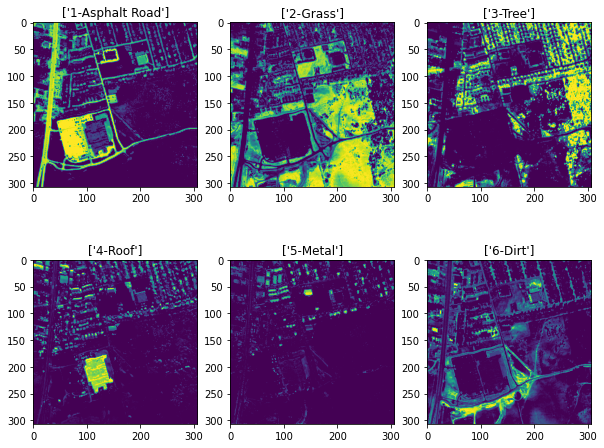

In [ ]:
data = sci.loadmat('Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations

gt = sci.loadmat('end6_groundTruth.mat')
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure(figsize=(10,8))
#TO DO : try to interpret the abundances that you see. Hint : the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    
    plt.title(gt['cood'][ii][0])


In [ ]:
print(gt['A'].shape)
for key in gt:
  print(key)

(6, 94249)
__header__
__version__
__globals__
cood
A
M
nEnd
nRow
nCol


In [ ]:
for key in data:
  print(key)

__header__
__version__
__globals__
X


- TO DO : is the near separable (aka pure pixel) assumption fulfilled on this dataset? Explain why.

- TO DO : we have access to the abundance **S_gt** groundtruth but not to the endmembers **A_gt**. Use your above answer to the to explain how the following code finds the endmembers. 
In particular, explain the use of the mean function (adding some plots to your report might be beneficial here).

**Question 1:**

is the near separable (aka pure pixel) assumption fulfilled on this dataset? Explain why.

**Answer:**

From paper "Robust Near-Separable Nonnegative Matrix Factorization
Using Linear Optimization": 

"In hyperspectral imaging, where each column of M equals the spectral signature of a
pixel, separability means that, for each constitutive material (endmember") present
in the image, there exists a pixel containing only that material. This assumption is
referred to as the pure-pixel assumption, and is in general satisfied for high-resolution
hyperspectral images." 

**Question 2:**

we have access to the abundance **S_gt** groundtruth but not to the endmembers **A_gt**. Use your above answer to the to explain how the following code finds the endmembers. 
In particular, explain the use of the mean function (adding some plots to your report might be beneficial here).

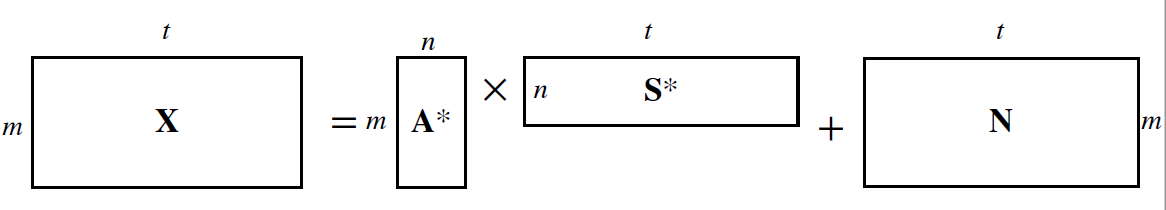

In [ ]:
print(X.shape)
print(abundances.shape)

(162, 94249)
(6, 94249)


In [ ]:
print(np.max(abundances))
print(np.sum(np.abs(abundances), axis=0))

1.0
[1. 1. 1. ... 1. 1. 1.]


**Answer:**

The following code use the property that the L1 norm of each colomn of S is 1. So we first try to find the index of colomn whose value is 1 in row $i$ of S (the other value in this colomn must be 0) and then we know that, by matrix multiplication, the corresponding colomn in X will be the value of A in colomn $i$. Now that, we have noise and in general, we have more than one index of colomn whose value is 1 in S, so we can average the value to be better robust to noise.

(<Figure size 432x288 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x7f2d01caf0d0>])

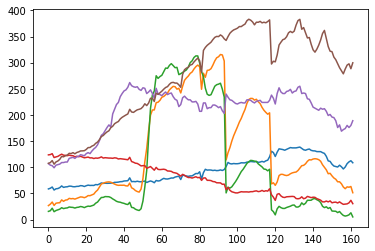

In [ ]:
endmembers= np.zeros((162,6))

for ii in range(6): 
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)


plt.figure(),plt.plot(endmembers)

**II - Near separable algorithm**

We will here implement the SPA (greedy) near-separable NMF algorithm and look at its practical efficiency.

1) Recall what near-separable NMF is.

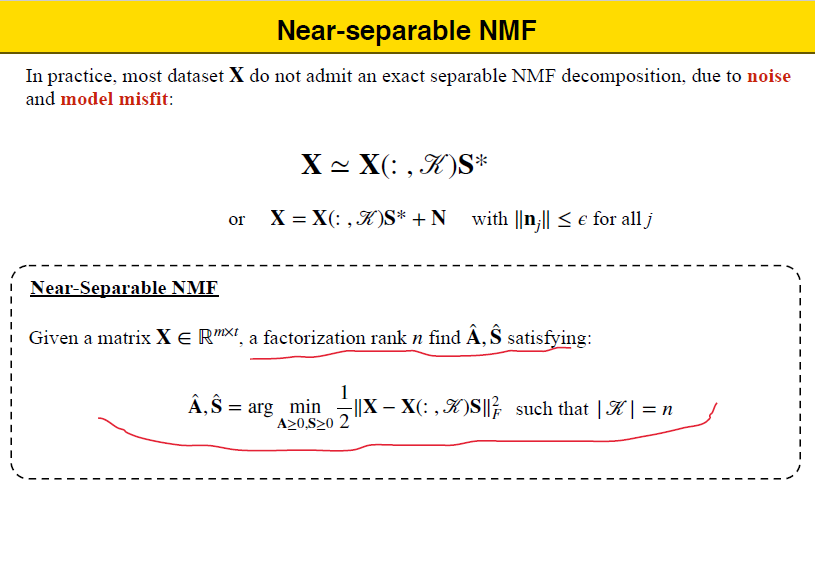

2) Implement the SPA algorithm

In [ ]:
def simpleSPA(Xin,r,optDisp=False): # TO DO. 
    
    X = Xin.copy()    
    
    K = np.zeros(r,dtype=int)
    
    R = X
    
    residual = np.zeros(r)
    for ii in range(r):
      K[ii] = np.argmax(np.sum(R**2, axis=0))
      
      R = (np.identity(R.shape[0]) - np.outer(R[:,K[ii]],R[:,K[ii]]) / np.sum(R[:,K[ii]]**2)) @ R 
      if optDisp == True:   
        print('Max residual %s'%np.max(R))
        residual[ii] = np.max(R)

    if optDisp == True:
      plt.plot(np.arange(1,r+1), residual)
      plt.plot(np.arange(1,r+1),residual,'*')
      plt.grid()
      plt.xlabel('iteration')
      plt.ylabel('Max residual')
    return K.astype(int)

3) Launch the SPA algorithm on the toy example.

Plot the residual at each iteration of SPA. 

How many sources can you at most extract ? Why ?

Max residual 6.35428182830545
Max residual 2.178771507823921
Max residual 7.576811650820097e-16


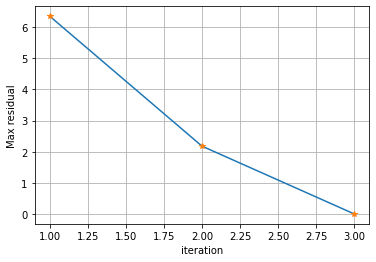

In [ ]:
K_SPA = simpleSPA(X_toy,3,optDisp = True)

**Answer:**

I think we can extract at most 3 sources, because after 3 iterations, the max residual is almost 0.

**4)** The code below enables to compute a separation metric to measure the separation accuracy of the BSS algorithms. 

Use the evalCriterion function to assess the quality of SPA on the real dataset.

Plot the endmembers found by your algorithm. How good are they?

In [ ]:
def norm_col(A):
    An = A.copy()
    type(An)
    for ii in range(np.shape(An)[1]):
        An[:,ii] = An[:,ii]/np.sqrt(np.sum(An[:,ii]**2));
    
    return An



        
def correctPerm(W0_en,W_en):
    # [WPerm,Jperm,err] = correctPerm(W0,W)
    # Correct the permutation so that W becomes the closest to W0.
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W0 = norm_col(W0)
    W = norm_col(W)
    
    costmat = -W0.T@W; # Avec Munkres, il faut bien un -

    
    m = Munkres()
    Jperm = m.compute(costmat.tolist())
    
    WPerm = np.zeros(np.shape(W0))
    indPerm = np.zeros(np.shape(W0_en)[1])
    
    for ii in range(W0_en.shape[1]):
        WPerm[:,ii] = W_en[:,Jperm[ii][1]]
        indPerm[ii] = Jperm[ii][1]
        
    return WPerm,indPerm.astype(int)




def evalCriterion(W0_en,W_en):
    # W0 : true mixing matrix
    # W : estimated mixing matrix
    #
    # maxAngle : cosine of the maximum angle between the columns of W0 and W
    
    W0 = W0_en.copy()
    W = W_en.copy()
    
    W,indPerm = correctPerm(W0,W);
    
    W0 = norm_col(W0_en)
    W = norm_col(W)

    diff = W0.T@W;
    
    return np.mean(np.diag(diff));

Max residual 603.4173437070264
Max residual 503.62039752697115
Max residual 202.62882898875796
Max residual 180.7841329331174
Max residual 160.99372330966375
Max residual 163.7149810941285
0.9149174369799747


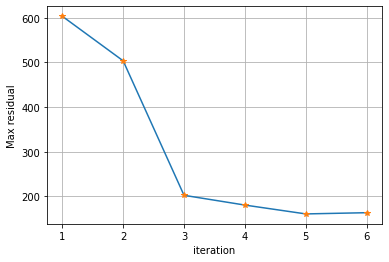

In [ ]:
K_SPA = simpleSPA(X,6,optDisp = True)

print(evalCriterion(endmembers, X[:,K_SPA]))

**Answer:**

This is rather good

**5)** (Bonus) The SPA algorithm gives you an estimation of the mixing matrix. Code an ISTA algorithm to obtain the corresponding sources (abundances). Plot them.

In [ ]:
def prox_l1(S_est,thrd):
  # To complete
  S_est = (np.abs(S_est)>=thrd)*(S_est - thrd*((S_est>=thrd)*2-1)) 
  return S_est

In [ ]:
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
   gamma = 0.9/np.sum(A.T @ A)
   S_est = np.zeros((A.shape[1], X.shape[1])) 
   i = 1
   while i<nbIt:
     S_est = prox_l1(S_est - gamma*A.T@(A@S_est - X), lamb)
     i += 1
   return S_est

In [ ]:
import scipy.fftpack as sff

In [ ]:
Xf = sff.dct(X)
S_estf = ISTA(Xf,A = X[:,K_SPA],n=6,lamb=0,nbIt = 1000)

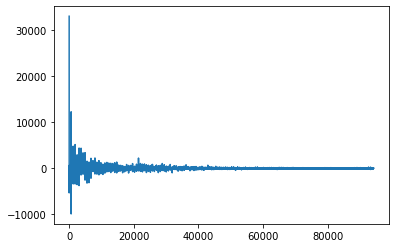

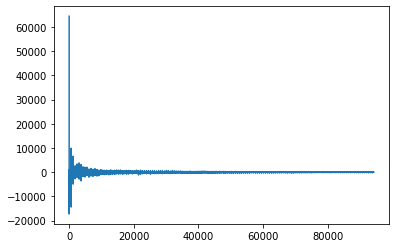

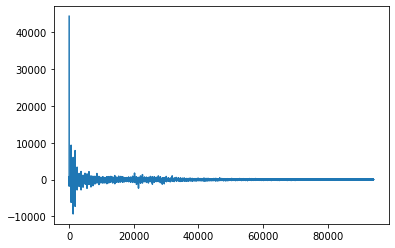

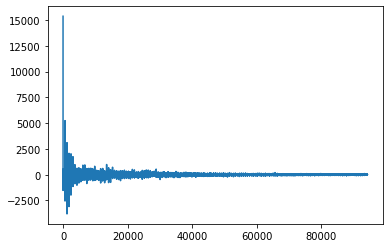

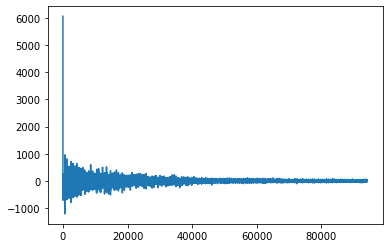

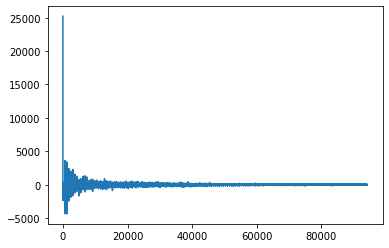

In [ ]:
# True sources

abundances_f = sff.dct(abundances)

for i in range(6):
  plt.figure()
  plt.plot(abundances_f[i,:])

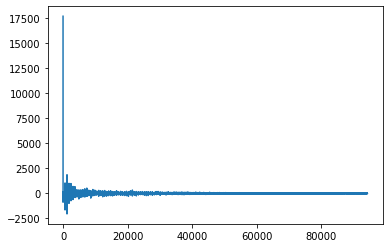

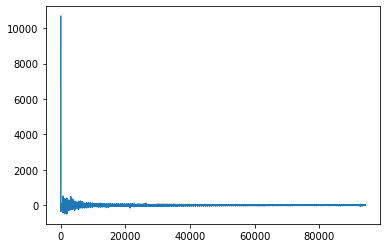

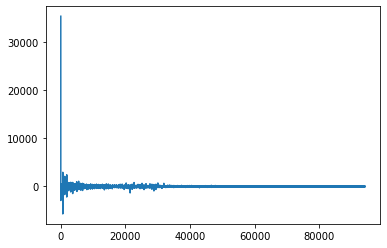

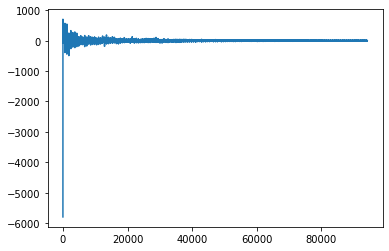

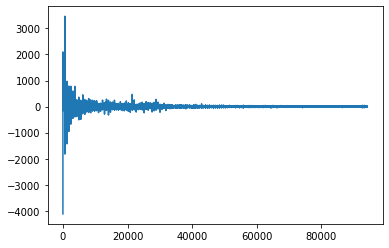

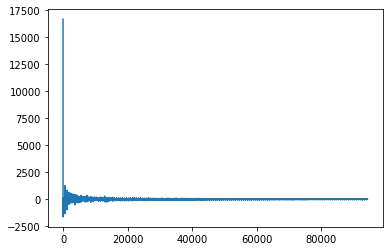

In [ ]:
# Estimated sources

for i in range(6):
  plt.figure()
  plt.plot(S_estf[i,:])

**III - PLAIN NMF**

In this part we use the PALM algorithm to perform plain NMF. Of course, if you already coded the PALM algorihtm with sparsity constriant in the previous TP, you can just adapt it.

This optimization scheme is simple but can provide decent separation results.

**1)** Write the cost function of plain NMF.

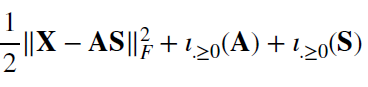

**2)** Implement the proximal operator of the nonnegativity constraint.

In [ ]:
def prox_positive(S): # TO DO
    return np.maximum(S,0)

**3)** Implement the PALM algorithm to solve the plain NMF problem.

In [ ]:
def PALM(X,n=2,nbIt = 100,Ainit=None,Sinit=None): # TO DO : reutiliser le PALM du TP precedent et l'adapter
  A_est = Ainit 
  S_est = Sinit  
  if A_est == None:
    A_est = np.random.rand(X.shape[0], n)
  if S_est == None:
    S_est = np.random.rand(n, X.shape[1]) 

  for i in range(nbIt):
    #  print(i, np.max(S_est))
    S_est = prox_positive(S_est + (0.9/(1e-6 + np.sum(A_est.T @ A_est))) * (A_est.T @ (X-(A_est@S_est))))
    A_est = prox_positive(A_est + (0.9/(1e-6 + np.sum(S_est @ S_est.T)))* ((X-A_est @ S_est) @ S_est.T))    
  return A_est,S_est

**4)** 
Launch the PALM algorithm on the real hyperspectral dataset. 

Can you find of a better initialization than the random one ?

Compare your result, both qualitatively and quantitatively, with the SPA algorithm. Explain the differences.

Plot the abundances.

In [ ]:
# CORRECTION
A_est,S_estf = PALM(Xf,n=6,nbIt = 1000,Ainit=None,Sinit=None) # TO DO: modify the initialization

In [ ]:
print(evalCriterion(endmembers, A_est))

0.8949167952506025


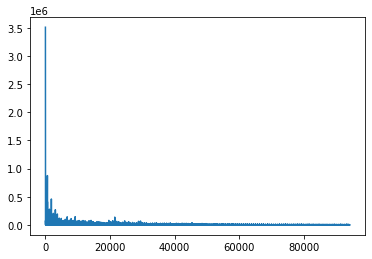

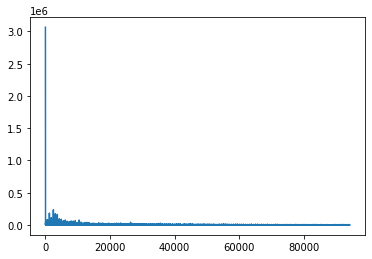

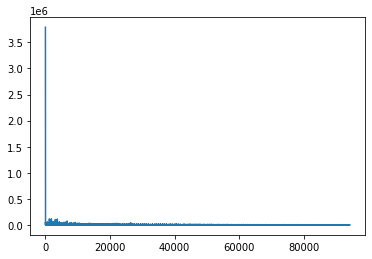

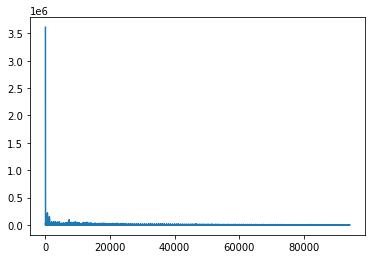

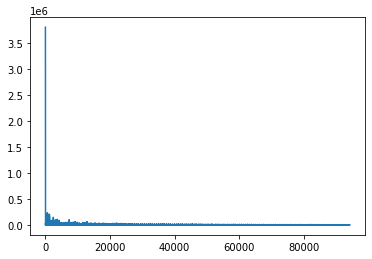

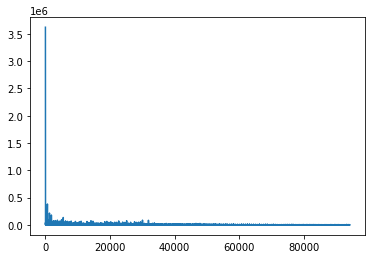

In [ ]:
# Estimated sources

for i in range(6):
  plt.figure()
  plt.plot(S_estf[i,:])

**Answer:**

Looking at the following image, I think we can initialize A using some pixels of observations. We can randomly choose r colomns of X as A. For S, we initialize it by solve $S = A^{-1}X$

I think this method can have a better result than SPA, but it's too slow

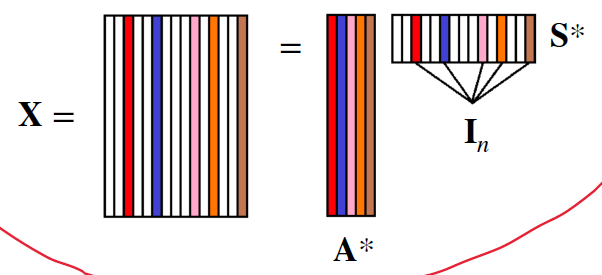

# End

# END

**IV - MINIMUM VOLUME NMF**

We finish this TP with the utilization of minimum volume NMF. As coding the corresponding algorithm is slightly above the objective of the classes, the code is fully given below.

In [ ]:
def simplexProx(X,epsilon = 0):
#     Given X,  computes its projection Y onto the simplex  

#       Delta = { x | x >= 0 and sum(x) <= 1 }, 

# that is, Y = argmin_z ||x-X||_2  such that z in S. 

# If X is a matrix, is projects its columns onto Delta to generate Y.


# ****** Input ****** 
# X       : m-by-r matrix
# epsilon : r-by-1 vector, generally positive and taken = 0

# ****** Output ****** 
# Y       : the projected matrix

    
    if np.isscalar(epsilon) == 1:
        epsilon = epsilon*np.ones(np.shape(X)[1]) 
    
    Y = np.zeros(np.shape(X))
    
    for ii in range(np.shape(X)[1]): # The prox is separable over the columns of X
        x = X[:,ii].copy() # We work on each column separately
        xsort = np.sort(x) # We need to sort the x value to apply the dichotomy
    
        index_min=0 # Index values for the dichotomy
        index_max=len(x)-1;
        
        # mu s.t. x_i > mu-epsilon, forall i
        mu_min=xsort[0]+epsilon[ii] # mu is the parameter required for the projection
    
        min_sum=np.sum(x)-len(x)*mu_min
        
        if min_sum < 1:# If the vector already satisfies the sum to at most one constraint
            mu=(np.sum(x)-1.)/np.float(len(x))
            y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu) # Element-wise max
            Y[:,ii]=y;
        else:
            # Use dichotomy for finding the optimal mu value
            stop = False
            it = 0
            while stop == False:
                it += 1
                
                cur_ind = int(np.round((float(index_min)+float(index_max)+1e-6)/2.))
                mu=xsort[cur_ind]+epsilon[ii]
                y=np.maximum(-epsilon[ii]*np.ones(len(x)), x-mu)
                
                val_constr = np.sum(y)
                if val_constr < 1.:
                    index_max=cur_ind # Because the objective is decreasing with mu and indMax > indMin
                elif val_constr > 1.:
                    index_min=cur_ind
                    
                else: # We found the best mu
                    Y[:,ii]=y
                    stop = True
                    
                    
                if index_max == index_min + 1:# This is a stopping condition, as the constraint function is piecewise linear
                    stop = True
                    
                    
            mu_inf=xsort[index_min]+epsilon[ii];
            mu_sup=xsort[index_max]+epsilon[ii];
            constr_inf = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_inf))
            constr_sup = np.sum(np.maximum(-epsilon[ii]*np.ones(len(x)),x-mu_sup))
                
            slope=(constr_sup-constr_inf)/(mu_sup-mu_inf)
            mu_opt=(1.-constr_inf)/slope+mu_inf # Because the constraint function is piecewise linear
            
            # Compute the corresponding column of Y
            y=np.maximum(-epsilon[ii]*len(x), x-mu_opt)
            
            Y[:,ii]=y
            
            
            
    return Y




#%%
def FGM_MM_nonneg(A,C,W0=0,maxiter=500,proj=1):
    # Fast gradient method to solve nonnegative least squares.  
    # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
    # Course, Kluwer Academic Publisher, 2004. 
    
    # This code solves: 
    
    #     min_{x_i in R^r_+} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 1
    #     min_{x_i in S} sum_{i=1}^m ( x_i^T A x_i - 2 c_i^T x_i ), if proj == 2 (with S = simplex)
    # [W,e] = FGMfcnls(A,C,W0,maxiter) 
    
    # ****** Input ******
    # A      : Hessian for each row of W, positive definite
    # C      : linear term <C,W>
    # W0     : m-by-r initial matrix
    # maxiter: maximum numbre of iterations (default = 500). 
    # proj   : =1, nonnegative orthant
    #          =2, nonnegative orthant + sum-to-one constraints on columns
    #
    # ****** Output ******
    # W      : approximate solution of the problem stated above. 
    # e      : e(i) = error at the ith iteration

    if np.isscalar(W0):
        W0 = np.zeros(np.shape(C));

    L = np.linalg.norm(A,2)# Pas evident...
    e = np.zeros(maxiter)
    # Extrapolation parameter
    beta = (1.-np.sqrt(np.linalg.cond(A))) / (1. + np.sqrt(np.linalg.cond(A))); 
    
    # Project initialization onto the feasible set
    if proj == 1:
        W = np.maximum(W0,0)
    elif proj == 2:
        W = simplexProx(W0)
        
    
    Y = W # Initialization of the second sequence (for the acceleration)
    ii = 0;
    eps0 = 0.
    eps = 1.
    delta = 1e-6
    
    while ii < maxiter and eps >= delta*eps0:
        # print("FGM_MM_nonneg, it %s"%ii)
        # Previous iterate
        Wp = W
        
        # FGM Coefficients  
        # alpha(i+1) = ( sqrt(alpha(i)^4 + 4*alpha(i)^2 ) - alpha(i)^2) / (2); 
        # beta(i) = alpha(i)*(1-alpha(i))/(alpha(i)^2+alpha(i+1)); 
        
        # Projected gradient step from Y
        W = Y - (Y@A-C) / L 
        
        # Projection
        if proj == 1:
            W = np.maximum(W,0.)
        elif proj == 2:
            W = simplexProx( W )
            
        
        # Linear combination of iterates
        Y = W + beta*(W-Wp)
        
        # Error
        e[ii] = np.sum((W.T@W)*A) - 2.*np.sum(W*C)
        
        
        # Restart: fast gradient methods do not guarantee the objective
        # function to decrease, a good heursitic seems to restart whenever it
        # increases although the global convergence rate is lost! This could
        # be commented out. 
        
        if ii >= 2 and e[ii] > e[ii-1]:
            Y = W
            
        if ii == 1:
            eps0 = np.sqrt(np.sum((W-Wp)**2))
        
        eps = np.sqrt(np.sum((W-Wp)**2))
        
        ii += 1
    return W,e

#%%
def nnls_FPGM(X,W,delta=1e-6,inneriter=500,proj=0,alpha0=0.05,H = 0,options=0 ):

     # Computes an approximate solution of the following nonnegative least
     # squares problem (NNLS)
    
     #           min_{H >= 0} ||X-WH||_F^2
     
     # using a fast gradient method; 
     # See Nesterov, Introductory Lectures on Convex Optimization: A Basic 
     # Course, Kluwer Academic Publisher, 2004. 
     
     # Input / Output; see nnls_input_output.m  
     
     # + options.proj allows to use a contraints on the columns or rows of H so 
     #   that the entries in each column/row sum to at most one 
     #   options.proj = 0: no projection (default). 
     #   options.proj = 1: projection of the columns on {x|x>=0, sum(x) <= 1} 
     #   options.proj = 2: projection of the rows {x|x>=0, sum(x) = 1} 
          
     # + options.alpha0 is the FPGM  extrapolation parameter (default=0.05). If options.alpha0 = 0 --> no acceleration, PGM
    

   
    
    # If no initial matrices are provided, H is initialized as follows: 
    if np.isscalar(H):
        H = np.zeros((np.shape(W)[1],np.shape(X)[1]))

    
    # Hessian and Lipschitz constant 
    WtW = W.T@W
    L = np.linalg.norm(WtW,2)
    # Linear term 
    WtX = W.T@X

    alpha = np.zeros(inneriter + 1)
    beta = np.zeros(inneriter)
    alpha[0] = alpha0
    
    if options == 0: # Project onto the non-negative orthant
        H = np.maximum(H,0)
    elif options == 1: # Project columns of H onto the simplex and origin
        H = np.maximum(H,0) 
        K = np.where(np.sum(H,axis=0) > 1.)[0] 
        H[:,K] = simplexProx( H[:,K] ) 
    elif options == 2: # Project rows of H onto the simplex
        H = simplexProx(H.T)
        H = H.T 
    
    
    
    Y = H # Second sequence
    ii = 0
    # Stop if ||V^{k}-V^{k+1}||_F <= delta * ||V^{0}-V^{1}||_F
    eps0 = 0
    eps = 1  
    while ii < inneriter and eps >= delta*eps0:
        # Previous iterate
        Hp = H; 
        # FGM Coefficients; see Nesterov's book
        alpha[ii+1] = ( np.sqrt(alpha[ii]**4 + 4*alpha[ii]**2 ) - alpha[ii]**2) / 2.
        beta[ii] = alpha[ii]*(1.-alpha[ii])/(alpha[ii]**2+alpha[ii+1])
        # Projection step
        H = Y - (WtW@Y-WtX) / L
        
        if options == 0:
            H = np.maximum(H,0);
        elif options == 1:
            H = np.maximum(H,0) # Project columns of H onto the set {x|x>=0, sum(x) <= 1} 
            K = np.where(np.sum(H,axis=0) > 1.)[0]
            H[:,K] = simplexProx( H[:,K] )  
        elif options == 2:
            H = simplexProx(H.T) # Project rows of H onto the simplex
            H = H.T
        
        # Linear combination of iterates
        Y = H + beta[ii]*(H-Hp)
        if ii == 1:
            eps0 = np.linalg.norm(H-Hp,'fro')
        
        eps = np.linalg.norm(H-Hp,'fro')
        ii = ii + 1; 
      


    return H,WtW,WtX





#%%
def normalizeWH(W,H,sumtoone,X): 
    # Normalization depending on the NMF model 
    if sumtoone == 1: # Normalize so that H^Te <= e entries in cols of H sum to at most 1
                      
        Hn = simplexProx( H );
        if np.linalg.norm(Hn - H) > 1e-3*np.linalg.norm(Hn):
           H = Hn
           # Reoptimize W, because this normalization is NOT w.l.o.g. 
           W,WtW_temp,WtX_temp = nnls_FPGM(X.T,H.T,H = W.T,inneriter=100)
           W = W.T
        
        H = Hn 
        
    elif sumtoone == 2: # Normalize so that He = e, entries in rows of H sum to 1
        scalH = np.sum(H,axis=1)
        H = np.diag( scalH**(-1) )@H
        W = W@np.diag( scalH )
        
    elif sumtoone == 3: # Normalize so that W^T e = e, entries in cols of W sum to 1
        scalW = np.sum(W,axis=0)
        H = np.diag( scalW )@H
        W = W@np.diag( scalW**(-1) )


    return W,H


#%%
def minvolNMF(X,r,W,H,lamb=0.1,delta=0.1,model=3,maxiter=100,inneriter=10,target = None):
    # W,H : initializations (W par SNPA, H par NNLS)

    # Normalization
    W,H = normalizeWH(W,H,model,X) # OM pour modele 2
    # Initializations
    normX2 = np.sum(X**2)
    normX = np.sqrt(normX2)
    
    WtW = W.T@W;
    WtX = W.T@X;
    
    err1 = np.zeros(maxiter)
    err2 = np.zeros(maxiter)
    e = np.zeros(maxiter)
    
    # Initial error and set of of lambda
    err1[0] = np.maximum(0,normX2-2.*np.sum(WtX*H)+np.sum(WtW*(H@H.T)))
    err2[0] = np.log(np.linalg.det(WtW + delta*np.eye(r)));  #OK
    
    lamb = lamb * np.maximum(1e-6,err1[0]) / (np.abs( err2[0] ))
    
    e[0] =  err1[0] + lamb * err2[0] # OK

    
    
    # projection model for H
    if model == 1:
        proj = 1
    elif model == 2:
        proj = 2
    elif model == 3:
        proj = 0
    
    
    # Main loop 
    
    for ii in range(1,maxiter):
        print(ii)
        #*** Update W ***
        XHt = X@H.T
        HHt = H@H.T
        
        Y = np.linalg.inv( ( W.T@W + delta*np.eye(r) ) )
        A = lamb*Y + HHt
        
        if model <= 2:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=1)
        elif model == 3:
            W,irr = FGM_MM_nonneg(A,XHt,W,inneriter,proj=2)

        # *** Update H ***
        Hinit = H
        
        H,WtW,WtX = nnls_FPGM(X,W,H=Hinit,proj=proj,inneriter=inneriter,delta=delta)
        
        err1[ii] = np.maximum(0, normX2 - 2.*np.sum(WtX*H)  + np.sum(WtW*(H@H.T)))
        err2[ii] = np.log(np.linalg.det(WtW + delta*np.eye(r)))
        
        e[ii] = err1[ii] + lamb * err2[ii]
        
        # Tuning lambda to obtain options.target relative error
        if np.isscalar(target):
            if np.sqrt(err1[ii])/normX > target+0.001:
                lamb = lamb*0.95
            elif np.sqrt(err1[ii])/normX < target-0.001:
                lamb = lamb*1.05
                
                
    return W,H,e,err1,err2

**1)** Launch the minvolNMF algorithm, by finding a good initialisation.

In [ ]:
[W3_t,H3_t,e3_t,er13_t,er23_t] = utils.minvolNMF(X,W=...,H=...,r=6,lamb=1.,maxiter=1000,target=0.05,model=1)

**2)** Compute the separation metric with the result of the minVol algorithm. Plot the abundances. Conclude on the different NMF algorithms.